In [1]:
import pandas

size_log = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
aborts = pandas.read_pickle("5-generated-mdps/fail.pkl.gz")

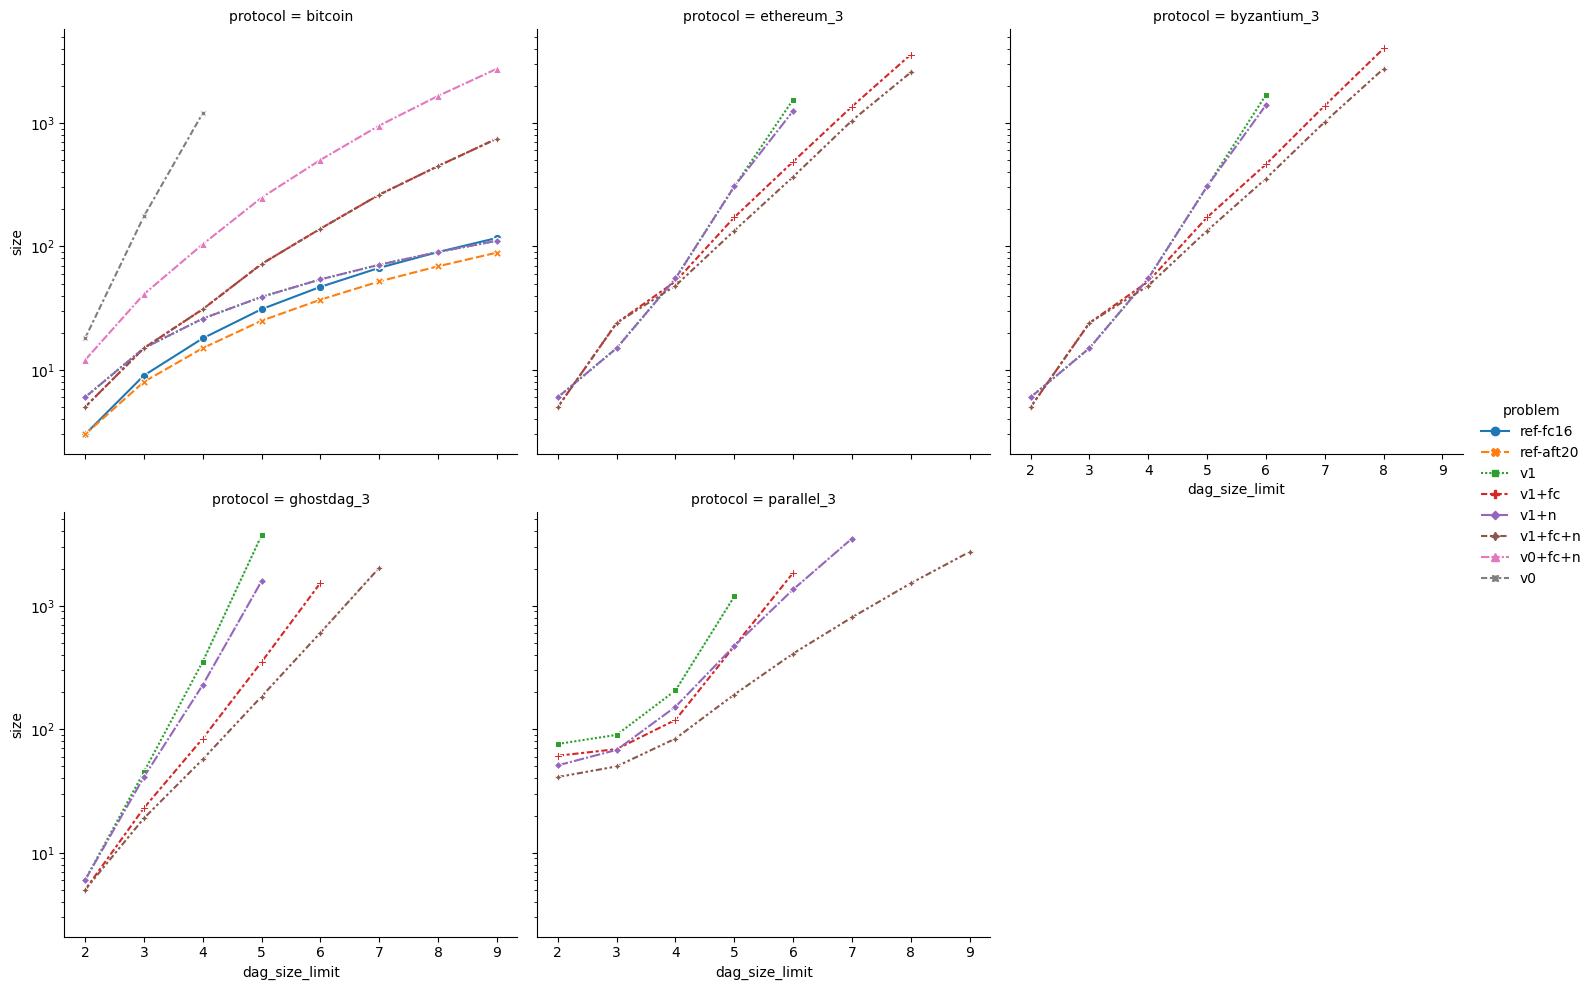

In [2]:
import seaborn

seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")

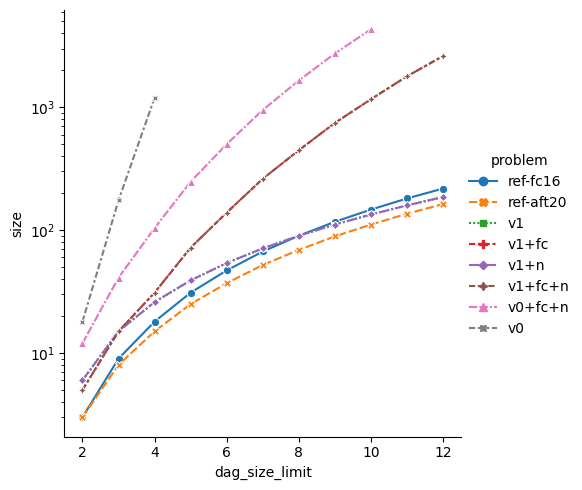

In [3]:
seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and dag_size_limit < 13"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
).set(yscale="log")

In [4]:
cutoff = (
    max(
        size_log.query(
            "problem.str.startswith('v1') and protocol == 'bitcoin'"
        ).dag_size_limit
    )
    + 1
)

btc_size = (
    size_log.query("protocol == 'bitcoin'")
    .query(f"dag_size_limit <= {cutoff}")
    .loc[:, ["dag_size_limit", "problem", "size"]]
    .drop_duplicates()
    .pivot(index="dag_size_limit", columns="problem", values="size")
)

btc_size.to_csv("5-state-space-exploration-viz-for-paper-btc-size.csv")
btc_size

problem,ref-aft20,ref-fc16,v0,v0+fc+n,v1,v1+fc,v1+fc+n,v1+n
dag_size_limit,,,,,,,,
2,3.0,3.0,18.0,12.0,6.0,5.0,5.0,6.0
3,8.0,9.0,175.0,41.0,15.0,15.0,15.0,15.0
4,15.0,18.0,1198.0,104.0,26.0,31.0,31.0,26.0
5,25.0,31.0,NaN,248.0,39.0,72.0,72.0,39.0
6,37.0,47.0,NaN,501.0,54.0,139.0,139.0,54.0
...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,4346.0,NaN,NaN,4346.0
65,NaN,NaN,NaN,NaN,4479.0,NaN,NaN,4479.0
66,NaN,NaN,NaN,NaN,4614.0,NaN,NaN,4614.0


In [5]:
# how should we report on the other protocols?
# column a: show max depth explored in table for fully optimized exploration only; calculate blow up factor and add as columns


def tabulate_deepest(d):
    return d.iloc[d.groupby(["problem", "protocol"]).dag_size_limit.idxmax()]


biggest = (
    tabulate_deepest(size_log)
    .reset_index(drop=True)
    .query("not problem.str.startswith('v1-')")
)

biggest.to_pickle("5-generated-mdps/biggest.pkl.gz")

biggest

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,63,4868,0.133139,0.183880,1ef83ee4
1,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,54,4943,0.170913,0.184856,7093eeb4
2,v0,generic-v0,False,False,True,True,True,bitcoin,4,1198,0.472799,0.264786,25bf7d76
3,v0+fc+n,generic-v0,True,True,True,True,True,bitcoin,10,4315,4.268752,0.264786,2b60c9de
4,v1,generic-v1,False,False,True,True,True,bitcoin,68,4890,27.408208,0.360245,18c46d9f
5,v1,generic-v1,False,False,True,True,True,byzantium_3,6,1685,1.389821,0.245605,26277d91
6,v1,generic-v1,False,False,True,True,True,ethereum_3,6,1544,1.132653,0.244141,1e641f86
7,v1,generic-v1,False,False,True,True,True,ghostdag_3,5,3712,2.642067,0.259243,b1477cae
8,v1,generic-v1,False,False,True,True,True,parallel_3,5,1189,0.612390,0.255962,16dec46e
9,v1+fc,generic-v1,True,False,True,True,True,bitcoin,13,3780,5.192942,0.277077,7fcd0f8f


In [6]:
# how should we report on the other protocols?
# column b: fix depth in table

fixed_cutoff = min(biggest.dag_size_limit)
fixed = (
    size_log.query("not problem.str.startswith('v1-')")
    .query(f"dag_size_limit == {fixed_cutoff}")
    .reset_index(drop=True)
)
fixed.to_pickle("5-generated-mdps/fixed.pkl.gz")
fixed

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,time_spent,rss,mdp
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,0.000616,0.175484,27186b8b
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,0.000429,0.183880,7604fec8
2,v1,generic-v1,False,False,True,True,True,bitcoin,4,26,0.014376,0.183880,7bbe74df
3,v1,generic-v1,False,False,True,True,True,ethereum_3,4,55,0.029269,0.229248,f2e913f9
4,v1,generic-v1,False,False,True,True,True,byzantium_3,4,55,0.032133,0.227905,2a330128
5,v1,generic-v1,False,False,True,True,True,ghostdag_3,4,352,0.170751,0.229103,170c6988
6,v1,generic-v1,False,False,True,True,True,parallel_3,4,206,0.082394,0.245342,58ef7aaf
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin,4,31,0.013185,0.228882,ecb1a34b
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,4,52,0.026929,0.236061,f1a86ee9
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,4,52,0.035271,0.237446,119aec2a


In [7]:
combined = pandas.DataFrame(
    dict(
        max_dag_size_limit=biggest.set_index(["problem", "protocol"]).dag_size_limit,
        size_at_fixed_dag_size=fixed.set_index(["problem", "protocol"])["size"],
    )
).reset_index()
combined

ValueError: cannot handle a non-unique multi-index!

In [ ]:
fixed_cutoff

In [ ]:
combined.query('problem.str.startswith("v1")').set_index(
    ["problem", "protocol"]
).unstack(level=0).stack(level=0, future_stack=True).unstack(level=1)